# Brownian motion simulation for asset price

### Math
1. We generate the drift coefficient and diffusion:\
$\mu_k = (r(t_k)-q(t_k))-\dfrac{1}{2}\sigma(t)^2\triangle t_k$\
$\delta_k = \sigma(t_k)\sqrt{\triangle t_k}$\
This happens at every step in a general case but in the case of this simple simulation, $r$, $q$, and $\sigma$ are constant to they only need to be computed once.

2. Next, we can calculate delta log price:\
$dlogS = \mu + \delta * \Z_{i,k}$, where $\Z_{i,k}$ is a gaussian shock along path $i$ and step $k$.
In this application the shocks are generated preemptively using the ```numpy.random.randn()``` function with parameters $M$ paths and $N$ steps per path, resulting in a $MxN$ array of shocks. In this case, $dlogS$ is a the $MxN$ matrix of shocks created by scaling by $\delta$ and adding $\mu$ to every element.

3. We can then use ```np.cumsum()``` to accumulate $dlogS$ which creates a rolling summation of log price. 

4. Finally we can exponentiate $logS$ and scale by $S_0$ to achieve our price path. 



In [33]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt

def simulate_gbm_paths(
   S0 = 100, #initial price
   T = 1.0, #maturity
   r = 0.05, #risk-free rate
   q = 0.0, #dividend yield
   sigma = 0.2, #annualized vol
   M = 10000, # number of paths
   N = 252, #steps per path
   seed = 42 #seed rng
):
   seed += rand.randint(0,100000)
   np.random.seed(seed)
   dt = T/N
   # drift and diffusion
   mu = (r - q - 0.5 * sigma**2) * dt
   diff = sigma * np.sqrt(dt)

   # generate standard normals Z of shape (M, N) (random shocks)
   Z = np.random.randn(M, N)
   
   dlogS = mu + diff * Z

   log_paths = np.cumsum(dlogS, axis=1)
   log_paths = np.hstack([np.zeros((M,1)), log_paths])  # prepend S0 at t=0

   # exponentiate and scale by S0
   paths = S0 * np.exp(log_paths)
   return paths

We also calculate a forward curve to determine fair price of the option:\
$F_{0,T} = S_0e^{(r-q)T}$\
With $F_{0,T}$ being the expected value of the asset in the future under risk-neutral measure. From this one can see that higher volatility will increase the spread of the paths around $F_{0,T}$.

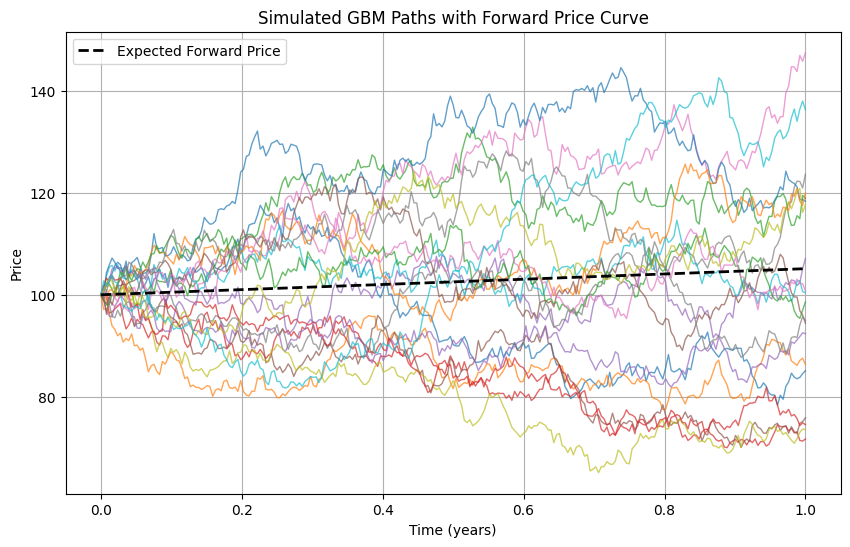

In [34]:
# parameters (some optional)
S0, T, r, q, sigma = 100, 1.0, 0.05, 0.0, 0.2
M, N = 20, 252

# Simulate paths
paths = simulate_gbm_paths(sigma = 0.22, M = 20)

t = np.linspace(0, T, N+1)

# Expected forward price curve under risk-neutral measure
forward_curve = S0 * np.exp((r - q) * t)

# plot with matplotlib
plt.figure(figsize=(10,6))
for i in range(paths.shape[0]):
    plt.plot(t, paths[i], lw=1, alpha=0.7)
plt.plot(t, forward_curve, "k--", lw=2, label="Expected Forward Price")
plt.title("Simulated GBM Paths with Forward Price Curve")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()



### Future plans

I will continue working on projects like this in the future. Possible expansions include:

1. Local vol
2. Calculate greeks
3. Multi-asset extension
4. Realized vs. Implied volatility using the data generated by GBM
5. Jumps (Poisson draw at each step for number of jumps and multiply by lognormal jump sizes, adjusted drift by $-\lambda \mu_j$)
6. Heston
